# 📊 Exploratory Data Analysis (EDA)

**Objective:** Understand the characteristics of the cleaned dataset before training models.

### 🔍 Key Questions:
1.  **Class Balance:** Are the topics evenly distributed?
2.  **Text Length:** How long are the articles? Are there outliers (too short/long)?
3.  **Vocabulary:** What are the most common words? Are there remaining stop words?
4.  **Data Quality:** Are there any null or duplicate values left?

In [1]:
# --- 1. SETUP & IMPORTS ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from wordcloud import WordCloud

# --- CONFIGURATION ---
# Adjust path relative to 'notebooks' folder: Go up one level (..) then into data/final
PROJECT_ROOT = Path.cwd().parent
DATA_FILE = PROJECT_ROOT / "data" / "final" / "nlp_dataset.jsonl"

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print(f"📂 Reading data from: {DATA_FILE}")

📂 Reading data from: C:\Users\yello\PycharmProjects\NLP\data\final\nlp_dataset.jsonl


## 2. Load Data

In [2]:
try:
    df = pd.read_json(DATA_FILE, lines=True)
    print(f"✅ Successfully loaded {len(df)} articles.")
except ValueError:
    print("❌ Error: Could not load data. Check if 'nlp_dataset.jsonl' exists.")

# Quick look
df.head()

✅ Successfully loaded 115188 articles.


,text,label_name,label_id,filename
0,Một trong những phân khu sôi động nhất Hội chợ...,Ẩm thực,0,AT_DT_1.txt
1,Chủ đề về ẩm thực Hà thành luôn thu hút sự qua...,Ẩm thực,0,AT_DT_10.txt
2,"Tự làm bánh mỳ, bánh phở, nhập mắm tôm từ Việt...",Ẩm thực,0,AT_DT_11.txt
3,"Sóc nhỏ Phnom Pi, xã miền núi Tri Tôn, tỉnh An...",Ẩm thực,0,AT_DT_12.txt
4,"""Omakase"" trong tiếng Nhật mang ý nghĩa ""phó t...",Ẩm thực,0,AT_DT_13.txt


## 3. Class Distribution Analysis
Checking if the dataset is balanced across different topics. Imbalanced data can lead to biased models.

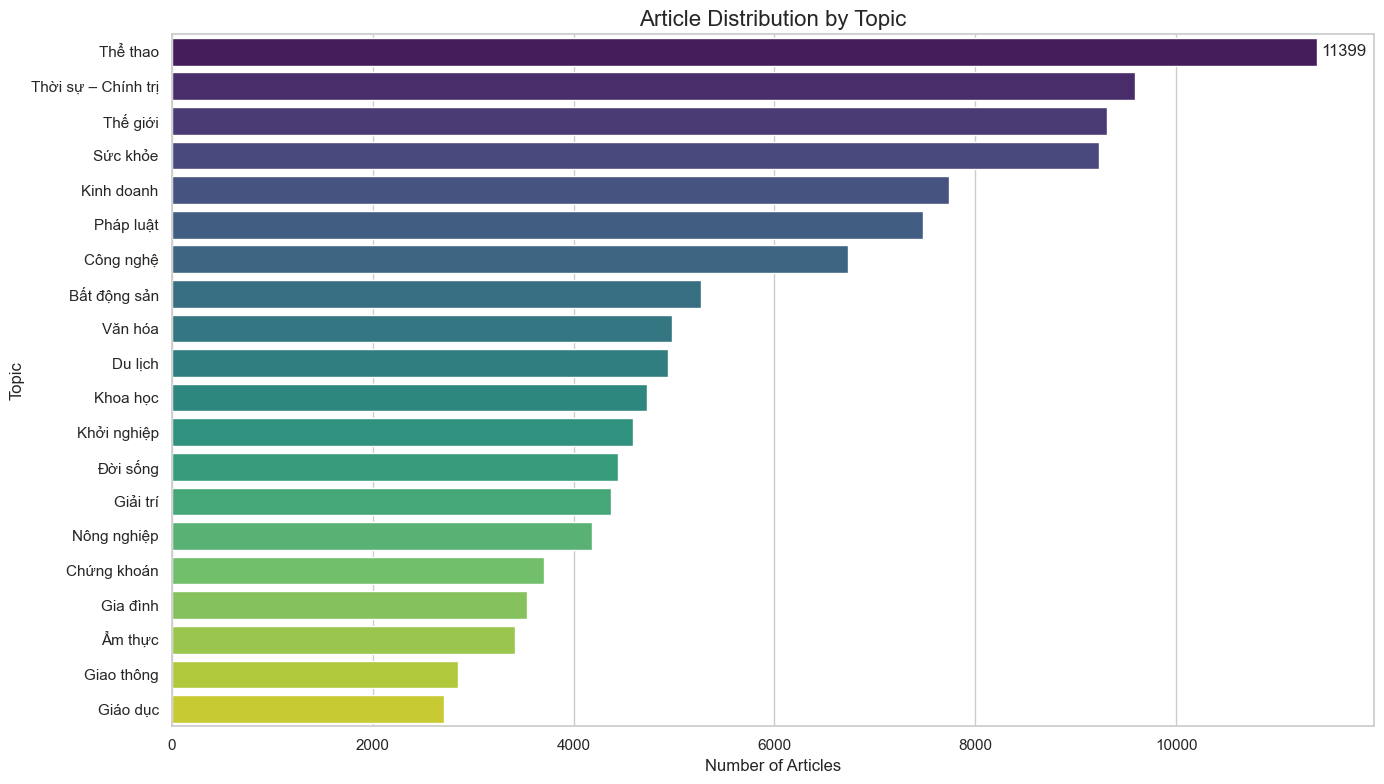

Max articles: 11399 (Thể thao)
Min articles: 2710 (Giáo dục)
Mean articles: 5759


In [3]:
# Count articles per topic
topic_counts = df['label_name'].value_counts().reset_index()
topic_counts.columns = ['Topic', 'Count']

# Visualization
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=topic_counts, x='Count', y='Topic', palette='viridis', hue='Topic', legend=False)

plt.title('Article Distribution by Topic', fontsize=16)
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('Topic', fontsize=12)
plt.bar_label(ax.containers[0], padding=3)
plt.tight_layout()
plt.show()

# Statistical Summary
print(f"Max articles: {topic_counts['Count'].max()} ({topic_counts.iloc[0]['Topic']})")
print(f"Min articles: {topic_counts['Count'].min()} ({topic_counts.iloc[-1]['Topic']})")
print(f"Mean articles: {topic_counts['Count'].mean():.0f}")

## 4. Text Length Analysis
Analyzing the number of words per article. This helps decide the `max_length` parameter for models (e.g., BERT usually handles up to 512 tokens).

**Note:** We use a simple whitespace split to estimate word count.

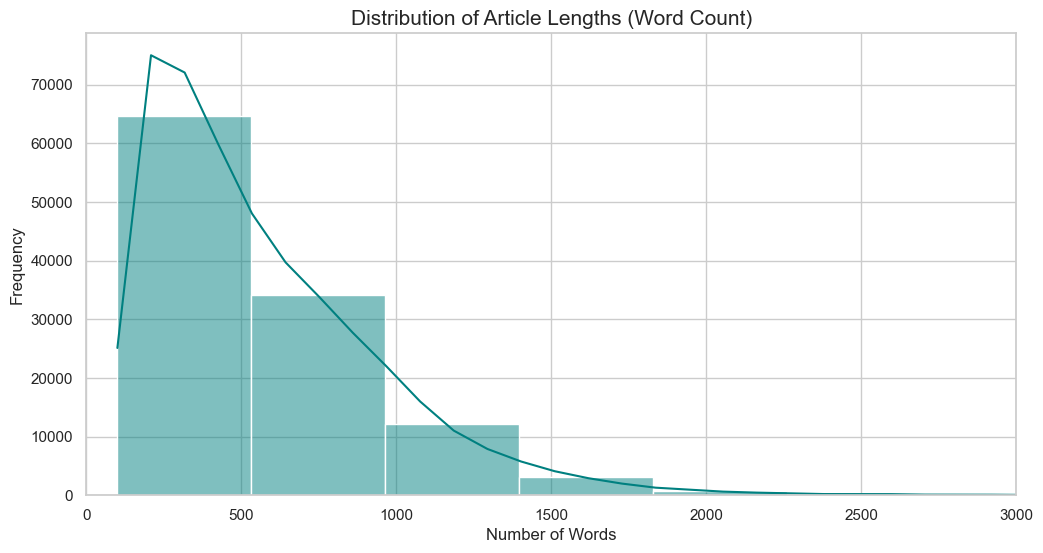

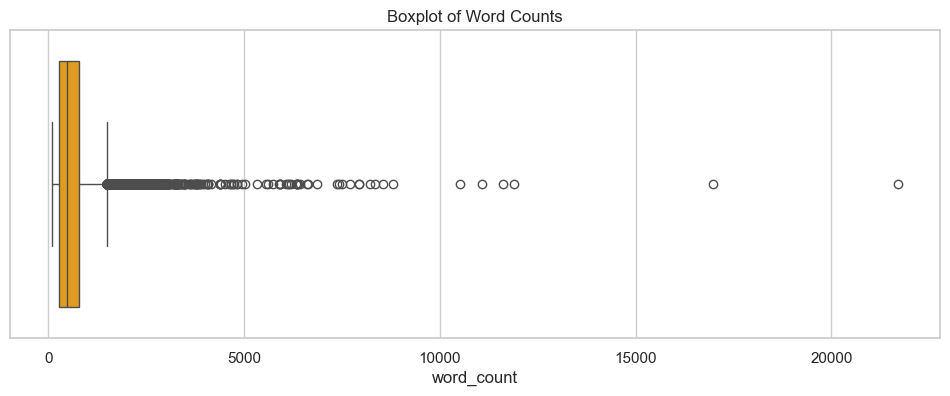

📊 Word Count Statistics:
count    115188.000000
mean        574.063218
std         411.563606
min         100.000000
25%         283.000000
50%         473.000000
75%         770.000000
max       21695.000000
Name: word_count, dtype: float64


In [4]:
# Calculate word counts
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Histogram
plt.figure(figsize=(12, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='teal')
plt.title('Distribution of Article Lengths (Word Count)', fontsize=15)
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 3000) # Limit view to 3000 words to ignore extreme outliers
plt.show()

# Boxplot to see outliers clearly
plt.figure(figsize=(12, 4))
sns.boxplot(x=df['word_count'], color='orange')
plt.title('Boxplot of Word Counts')
plt.show()

# Detailed Stats
print("📊 Word Count Statistics:")
print(df['word_count'].describe())

### ⚠️ Check for Anomalies
Looking for articles that are surprisingly short (potentially noise) or extremely long.

In [5]:
# Short articles check (< 50 words)
short_articles = df[df['word_count'] < 50]
print(f"⚠️ Found {len(short_articles)} articles with < 50 words.")

if not short_articles.empty:
    print("\n--- Sample Short Articles ---")
    display(short_articles[['label_name', 'word_count', 'text']].head(3))

# Long articles check (> 3000 words)
long_articles = df[df['word_count'] > 3000]
print(f"\n⚠️ Found {len(long_articles)} extremely long articles (> 3000 words).")

⚠️ Found 0 articles with < 50 words.

⚠️ Found 126 extremely long articles (> 3000 words).


## 5. Vocabulary Analysis (Word Cloud)
Visualizing the most frequent words to identify potential stop words or domain-specific terms.

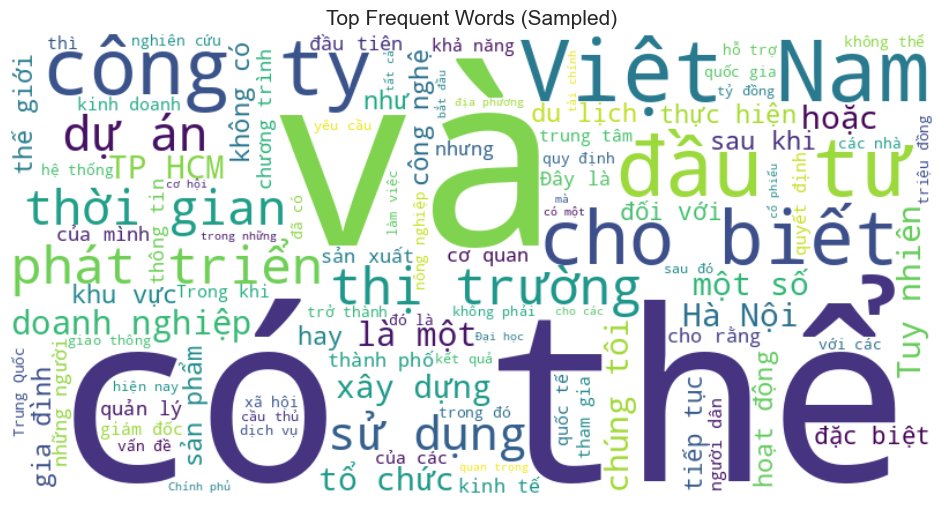

In [6]:
# Combine all text (take a sample to save RAM if dataset is huge)
sample_text = " ".join(df['text'].sample(frac=0.1, random_state=42).tolist())

# Generate WordCloud
# Note: WordCloud doesn't support Vietnamese fonts by default perfectly, 
# but works reasonably well for general analysis.
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(sample_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Frequent Words (Sampled)', fontsize=15)
plt.show()

## 6. Duplicate Check (Final Safety Net)
Even though we cleaned duplicates in Stage A, it's good practice to double-check in the final JSONL.

In [7]:
duplicates = df[df.duplicated(subset=['text'], keep=False)]
print(f"🔍 Duplicate text entries found: {len(duplicates)}")

if len(duplicates) > 0:
    print("Top duplicates:")
    display(duplicates.sort_values('text').head(4))

🔍 Duplicate text entries found: 0


## 7. Conclusion & Next Steps
Based on the analysis above:
* **Balance:** If one topic has very few samples, consider crawling more data or using augmentation.
* **Length:** If most articles are > 1000 words, we might need truncation for BERT models.
* **Cleaning:** If the WordCloud shows too many nonsense words or HTML tags, go back to `01_preprocessing.ipynb`.

**👉 Ready for:** `03_modeling.ipynb`